In [ ]:
# locally
import os
import sys


sys.path.append(os.path.dirname(os.getcwd()))

In [1]:
# on Kaggle
# import sys
# sys.path.append('/kaggle/input/gan-training')

# Обучение Wasserstein GAN на наборе данных MNIST

In [2]:
import torch

In [3]:
DATA_DIR = 'data_demo'

## Безусловная генерация

In [4]:
from pipeline.data import get_mnist_dataset, UnifiedDatasetWrapper

def form_dataset(train: bool = False) -> torch.utils.data.Dataset:
    return UnifiedDatasetWrapper(get_mnist_dataset(root=DATA_DIR, train=train, keep_labels=False))
    # чтобы не обрабатывать отдельно случае безусловных датасетов, все датасеты приводятся к условным

train_dataset = form_dataset(True)

100%|██████████| 9912422/9912422 [00:00<00:00, 86230900.40it/s]


Extracting data_demo/MNIST/raw/train-images-idx3-ubyte.gz to data_demo/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15824388.48it/s]

Extracting data_demo/MNIST/raw/train-labels-idx1-ubyte.gz to data_demo/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26274685.70it/s]


Extracting data_demo/MNIST/raw/t10k-images-idx3-ubyte.gz to data_demo/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7467867.02it/s]


Extracting data_demo/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_demo/MNIST/raw



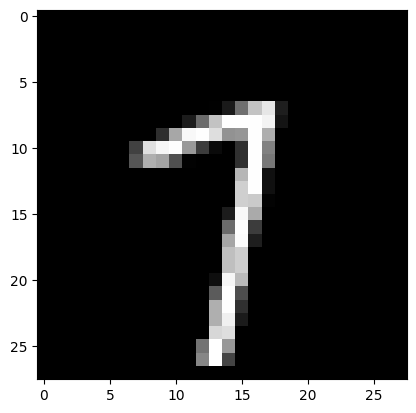

In [5]:
from visualization_aux.common import imshow

imshow(train_dataset[42][0], cmap='gray')

Т.к. большинство метрик заточены под физическую задачу (или их реализация заточена), для MNIST подходит только логирование распределения значений дискримнатора на истинных и генерируемых данных соответственно (помимо этого, во время обучения логируются разные статистики).

In [6]:
from pipeline.metrics import CriticValuesDistributionMetric, Metric


def form_metric() -> Metric:
    return CriticValuesDistributionMetric(values_cnt=1000)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Зададим логирование в WandB (чтобы повторить локально, небходимо задать переменную окружения `WANDB_TOKEN`)

In [7]:
import contextlib

from pipeline.wandb_logger import WandbCM


def init_logger(model_name: str):
    project_name = 'MNIST_GAN_DEMO'
    @contextlib.contextmanager
    def logger_cm():
        try:
            with WandbCM(project_name=project_name, experiment_id=model_name) as wandb_logger:
                yield wandb_logger
        finally:
            pass
    return logger_cm

Зададим гиперпараметры обучения:

In [8]:
from typing import Generator, Tuple

from pipeline.discriminators import MNISTDiscriminator
from pipeline.gan import GAN
from pipeline.generators import MNISTGenerator
from pipeline.normalization import apply_normalization, SpectralNormalizer
from pipeline.train import GanTrainer, Stepper, WganEpochTrainer


def form_gan_trainer(model_name: str, n_epochs: int) -> Generator[Tuple[int, GAN], None, GAN]:
    logger_cm_fn = init_logger(model_name)
    metric = form_metric()
    
    train_dataset = form_dataset(True)
    val_dataset = form_dataset(False)
    
    # зададим шум как вектор размерности 50
    noise_dimension = 50

    def uniform_noise_generator(n: int) -> torch.Tensor:
        return 2*torch.rand(size=(n, noise_dimension)) - 1  # [-1, 1]
    
    # используем готовые архитектуры моделей генератора и дискриминатора
    generator = MNISTGenerator(noise_dim=noise_dimension)
    discriminator = MNISTDiscriminator()
    
    # применим спектральную нормализацию к дискриминатору
    discriminator = apply_normalization(discriminator, SpectralNormalizer)
    
    gan_model = GAN(generator, discriminator, uniform_noise_generator)
    
    # зададим оптимизаторы
    generator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(generator.parameters(), lr=1e-3)
    )

    discriminator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(discriminator.parameters(), lr=1e-5)
    )
    
    # trainer для одной эпохи, используем Wasserstein GAN
    epoch_trainer = WganEpochTrainer(n_critic=5, batch_size=100)
    
    # теперь зададим trainer для всего процесса обучения
    # отключаем сохранение моделей для упрощения примера
    trainer = GanTrainer(model_dir=None, use_saved_checkpoint=False, save_checkpoint_once_in_epoch=0)
    train_gan_generator = trainer.train(gan_model=gan_model,
                                        train_dataset=train_dataset, val_dataset=val_dataset,
                                        generator_stepper=generator_stepper,
                                        critic_stepper=discriminator_stepper,
                                        epoch_trainer=epoch_trainer,
                                        n_epochs=n_epochs,
                                        metric=metric,
                                        logger_cm_fn=logger_cm_fn)
    
    return train_gan_generator

In [9]:
gan_trainer = form_gan_trainer(model_name='mnist demo', n_epochs=10)

Запустим обучение (если доступна CUDA, то для обучения будет использоваться GPU)

In [10]:
from visualization_aux.common import gen_several_images

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: trickman. Use `wandb login --relogin` to force relogin


100%|██████████| 600/600 [02:07<00:00,  4.69it/s]


epochs done: 1


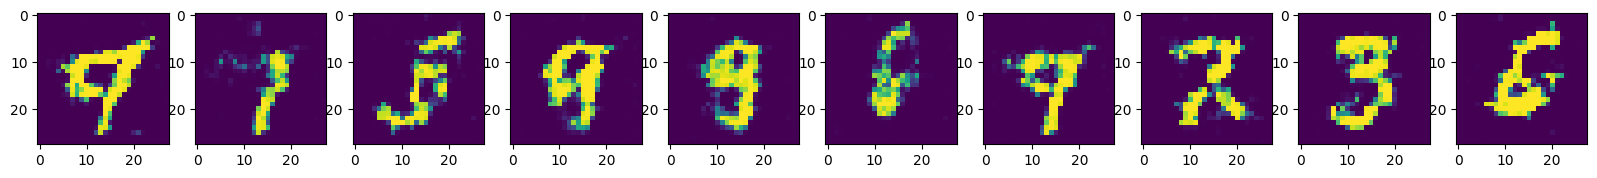

100%|██████████| 600/600 [01:58<00:00,  5.06it/s]


epochs done: 2


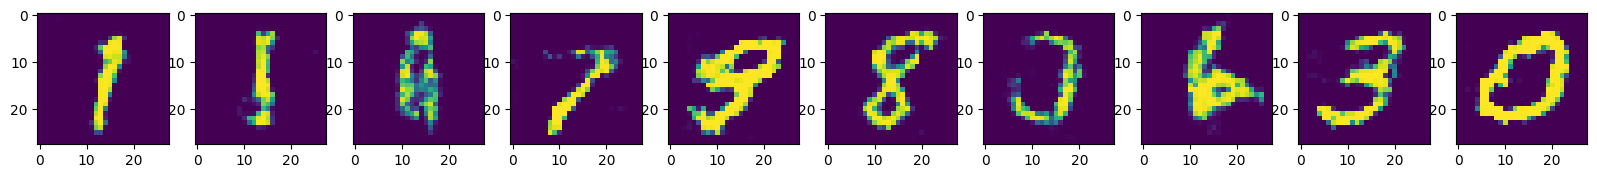

100%|██████████| 600/600 [01:59<00:00,  5.00it/s]


epochs done: 3


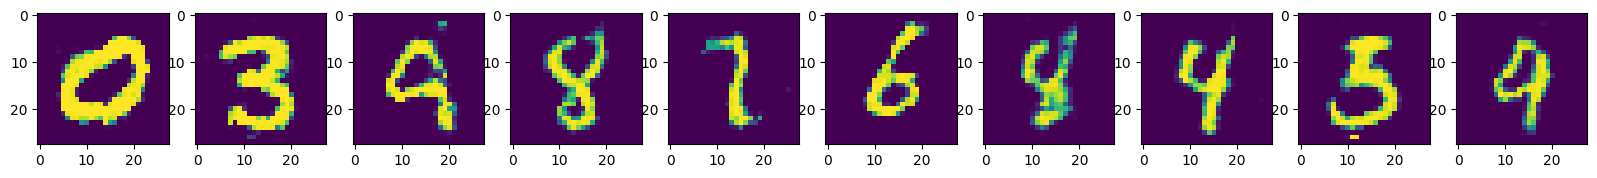

100%|██████████| 600/600 [01:59<00:00,  5.01it/s]


epochs done: 4


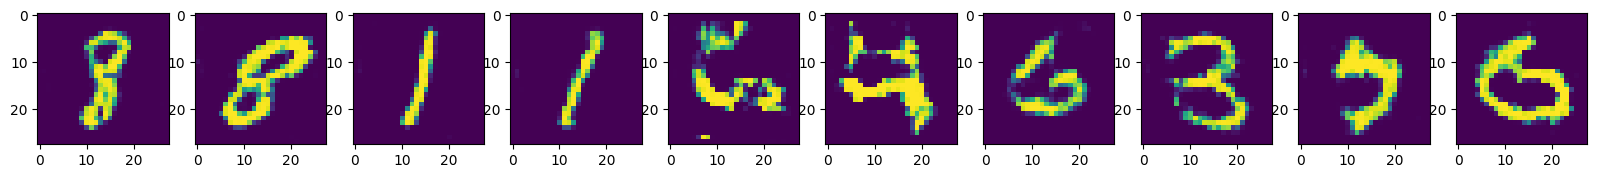

100%|██████████| 600/600 [01:59<00:00,  5.03it/s]


epochs done: 5


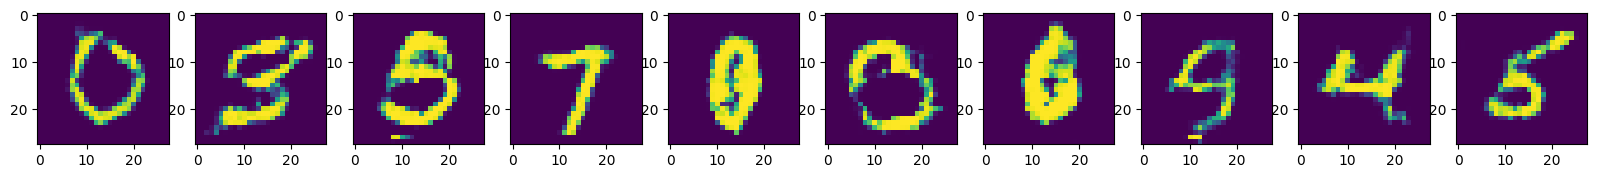

100%|██████████| 600/600 [01:58<00:00,  5.05it/s]


epochs done: 6


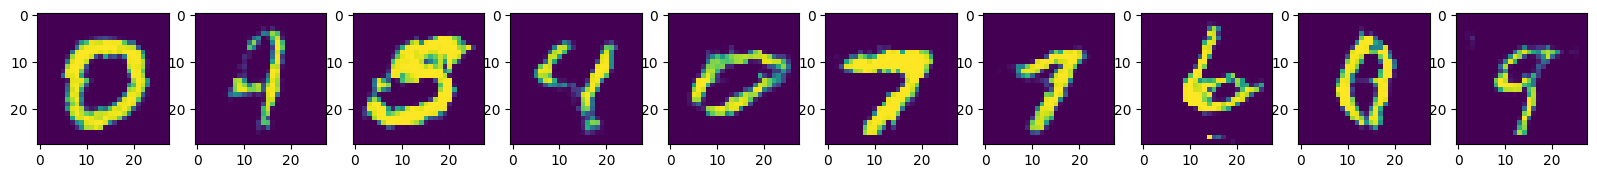

100%|██████████| 600/600 [01:58<00:00,  5.05it/s]


epochs done: 7


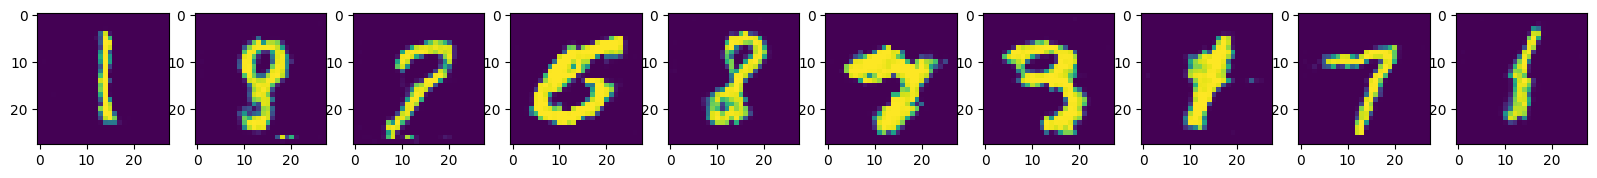

100%|██████████| 600/600 [01:59<00:00,  5.02it/s]


epochs done: 8


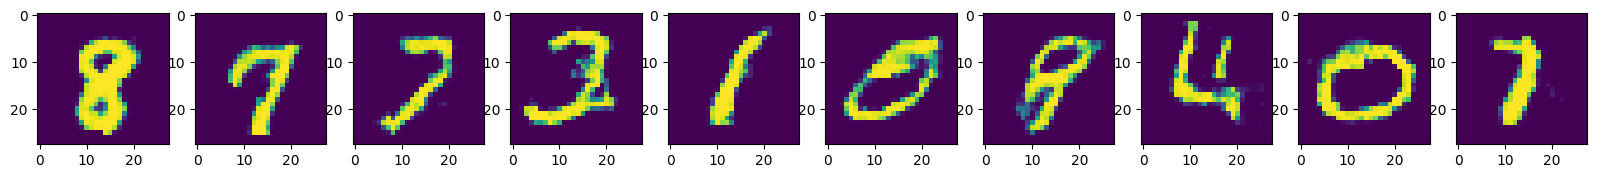

100%|██████████| 600/600 [02:00<00:00,  4.99it/s]


epochs done: 9


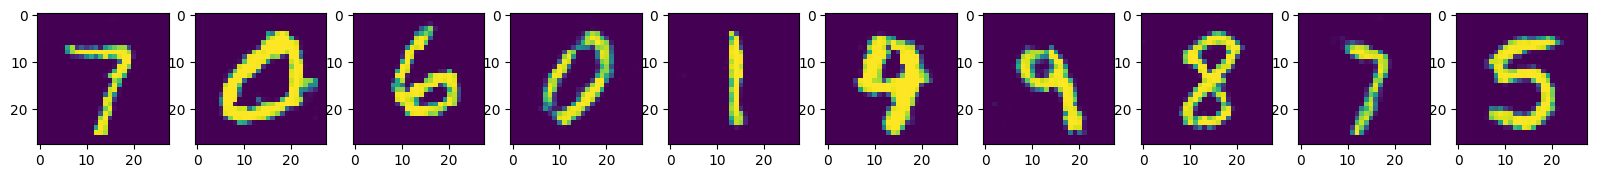

100%|██████████| 600/600 [02:00<00:00,  4.99it/s]


epochs done: 10


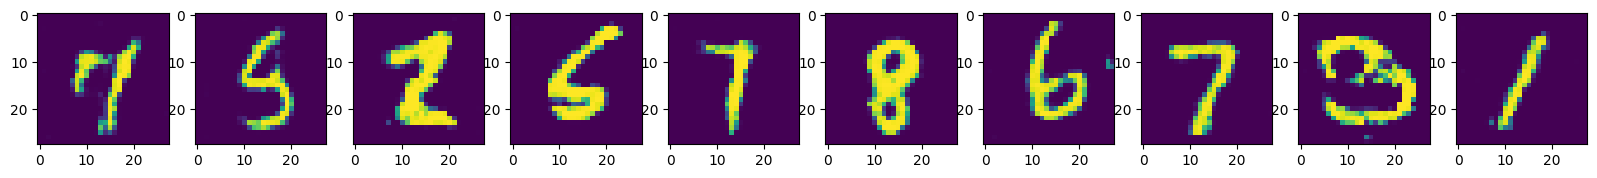

epoch,▁▂▃▃▄▅▆▆▇█
train/critic/adv_loss,██▇▆▅▄▄▃▂▁
train/critic/loss,▇█▇▆▅▅▄▃▂▁
train/discriminator/grad_norm,▁▁▂▂▃▄▅▆▇█
train/generator/adv_loss,▂▁▂▃▄▅▅▆▇█
train/generator/grad_norm,▁▂▂▃▄▅▅▆▇█
train/generator/loss,▂▁▂▃▄▅▅▆▇█
train/regularizer/loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
train/critic/adv_loss,-22.65726
train/critic/loss,-5.22321


In [11]:
for epoch, gan in gan_trainer:
    print(f'epochs done: {epoch-1}')
    gen_several_images(gan, 10, figsize=(20, 11))